In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os

## Camera Calibration

In [2]:
from undistortImg import camera_calibration, undistort_img

img_path_list = glob.glob('/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
mtx, dist = camera_calibration(img_path_list)

## Undistortion

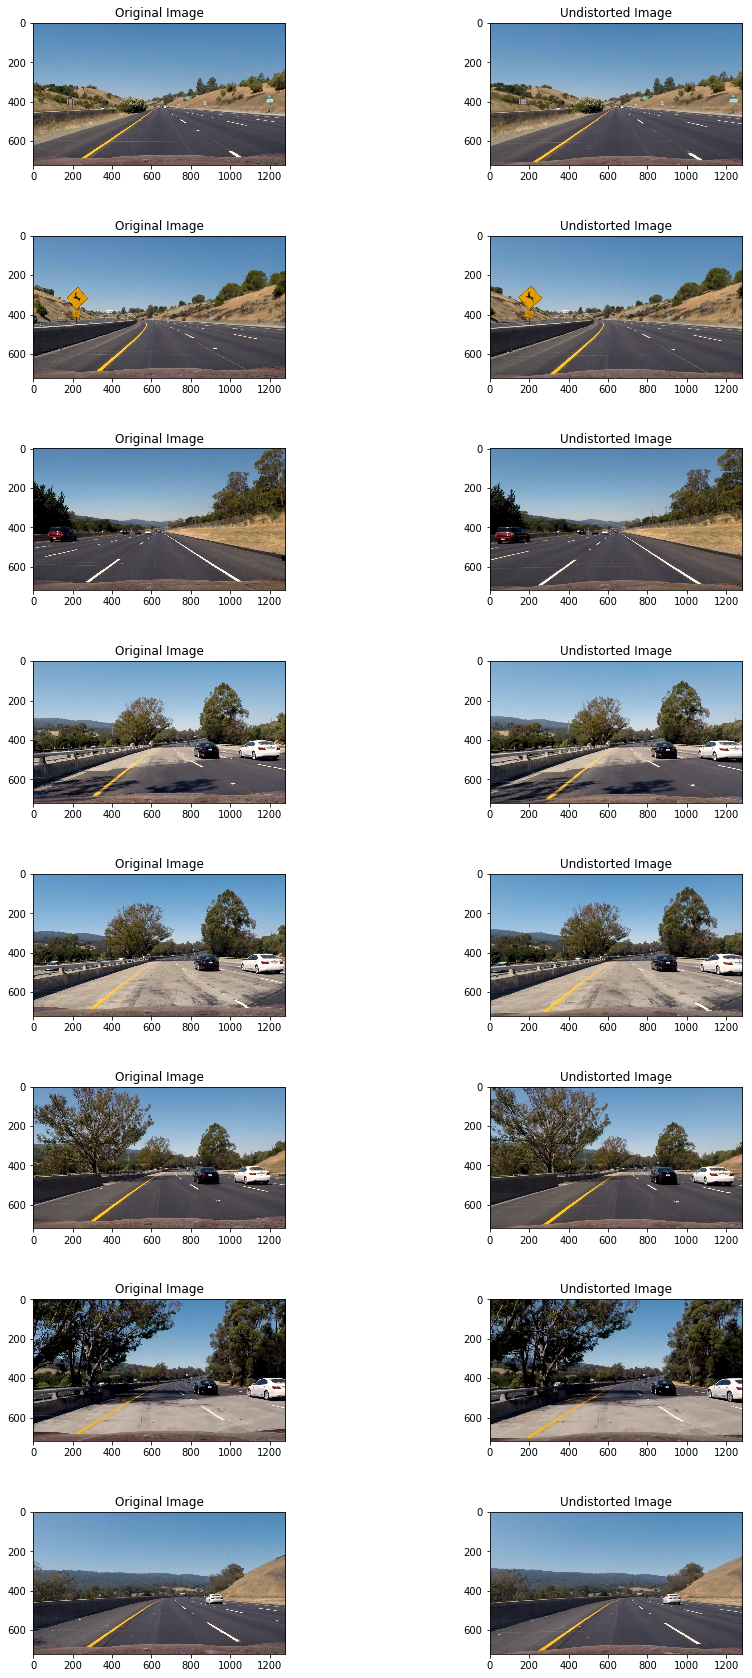

In [3]:
f, axes = plt.subplots(8,2,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

images = glob.glob('test_images/*.jpg') # Reading Images from test_images folder
original_images = []
undistorted_images = []
for index, image in enumerate(images):
    original_img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    original_images.append(original_img)
    axes[index,0].imshow(original_img)
    axes[index,0].set_title("Original Image")
    undistorted_img = undistort_img(original_img, mtx, dist) # undistorting image 
    undistorted_images.append(undistorted_img)
    if not os.path.exists('output_images/undistorted/'):
        os.makedirs('output_images/undistorted/')
    mpimg.imsave('output_images/undistorted/' + images[index].split('/')[-1], undistorted_img)
    axes[index,1].set_title("Undistorted Image")
    axes[index,1].imshow(undistorted_img)

## Binary Image Creation

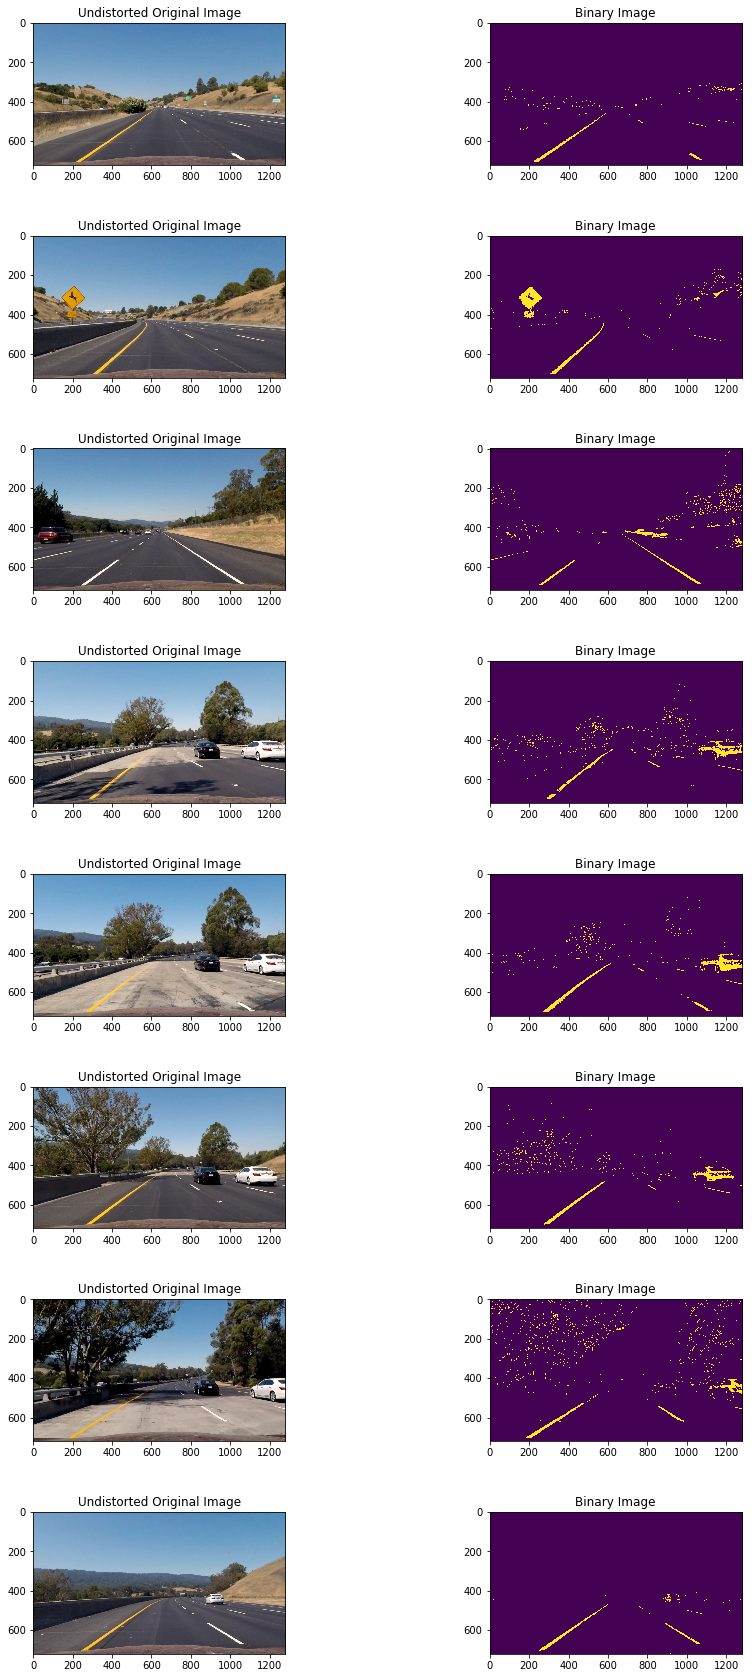

In [4]:
from colorChannel import create_threshold_binary

f, axes = plt.subplots(8,2,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

binary_images = []
for index, image in enumerate(undistorted_images):
    axes[index,0].imshow(image)
    axes[index,0].set_title("Undistorted Original Image")
    binary_img = create_threshold_binary(image) # apply color threshold 
    binary_images.append(binary_img)
    axes[index,1].set_title("Binary Image")
    axes[index,1].imshow(binary_img)
    if not os.path.exists('output_images/binary_image/'):
        os.makedirs('output_images/binary_image/')
    mpimg.imsave('output_images/binary_image/' + images[index].split('/')[-1], binary_img)

## Warp Perspective Transformation

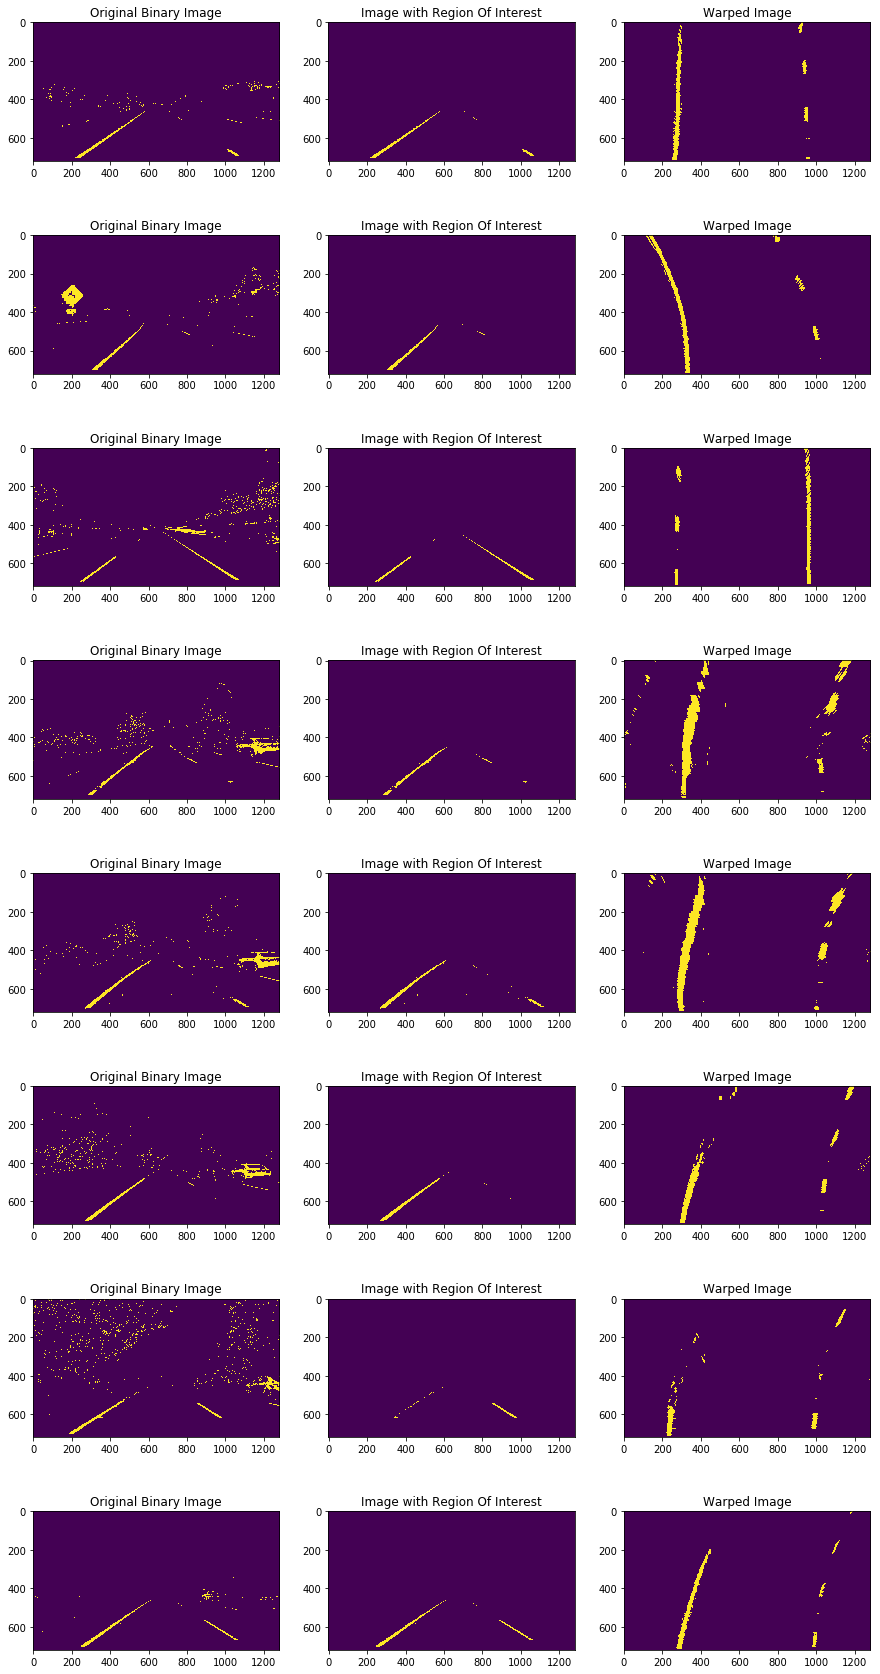

In [12]:
from warpingImage import warp_perspective, ROI

f, axes = plt.subplots(8,3,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

warped_images = []
M = None
for index, image in enumerate(binary_images):
    roi_image = image.copy()
    axes[index,0].imshow(image)
    axes[index,0].set_title("Original Binary Image")
    roi_image = ROI(roi_image)
    axes[index,1].imshow(roi_image)
    axes[index,1].set_title("Image with Region Of Interest")
    y=image.shape[0]
    x=image.shape[1]
    warped, M, M_inv = warp_perspective(image)
    warped_images.append(warped)
    axes[index,2].imshow(warped)
    axes[index,2].set_title("Warped Image")
    if not os.path.exists('output_images/warped_image/'):
        os.makedirs('output_images/warped_image/')
    mpimg.imsave('output_images/warped_image/' + images[index].split('/')[-1], warped)

## Lane Line Detection

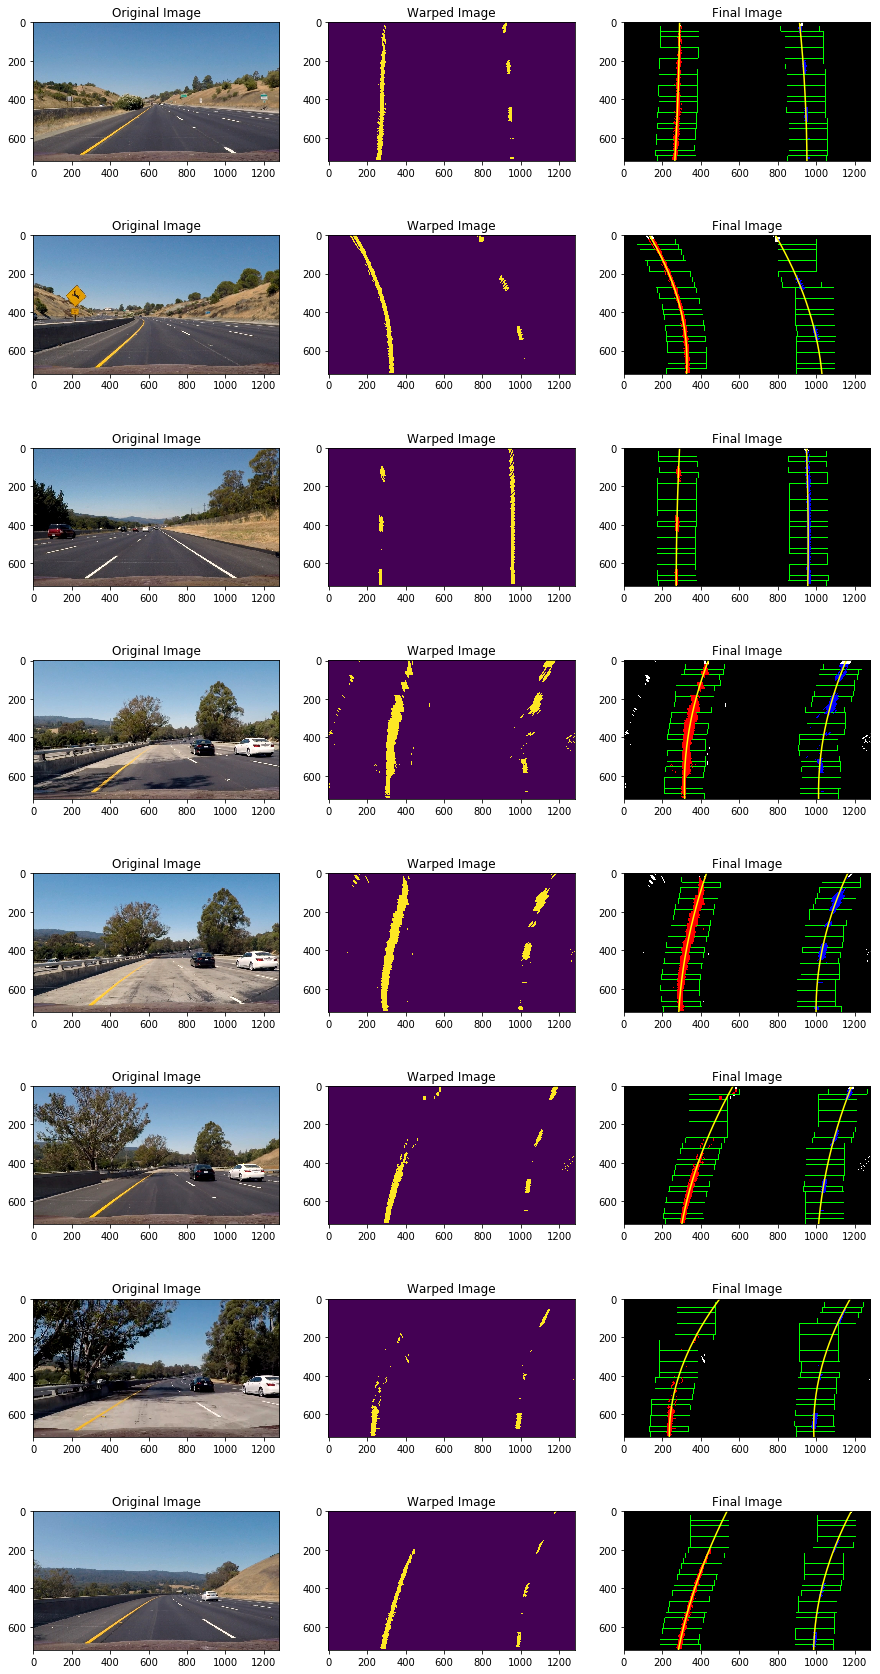

In [13]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

from lanePixelDetector import find_lanes

f, axes = plt.subplots(8,3,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

for index, image in enumerate(warped_images):
    axes[index,0].imshow(original_images[index])
    axes[index,0].set_title("Original Image")
    
    axes[index,1].imshow(image)
    axes[index,1].set_title("Warped Image")

    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, \
        out_img, nonzerox, nonzeroy = find_lanes(image, ym_per_pix, xm_per_pix)
    # Visualization
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    axes[index,2].imshow(out_img)
    axes[index,2].plot(left_fitx, ploty, color='yellow')
    axes[index,2].plot(right_fitx, ploty, color='yellow')
    axes[index,2].set_title("Final Image")
    if not os.path.exists('output_images/lane_detect/'):
        os.makedirs('output_images/lane_detect/')
    mpimg.imsave('output_images/lane_detect/' + images[index].split('/')[-1], out_img)

## Draw Safe Patch and Add Curvature Information on Original Image

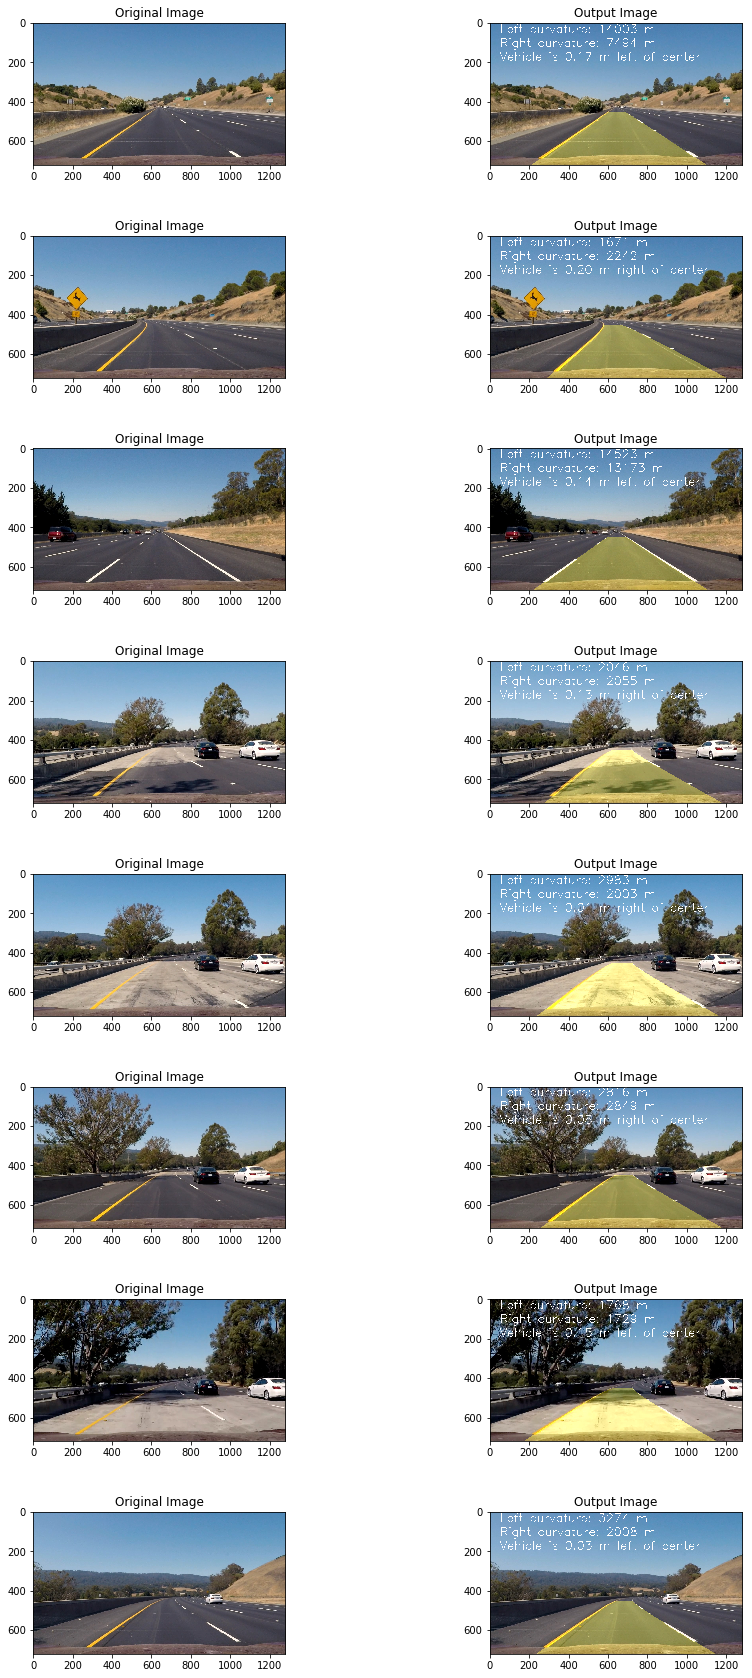

In [14]:
from laneDrawer import draw_patch, calculate_curvature

f, axes = plt.subplots(8,2,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

for index, image in enumerate(original_images):
    axes[index,0].imshow(image)
    axes[index,0].set_title("Original Image")
    left_fit, right_fit, left_fit_m, right_fit_m, _, _,  _, _, _ = find_lanes(warped_images[index], ym_per_pix, xm_per_pix)
    # Calculate Curvature
    y_range = image.shape[0]
    left_curvature = calculate_curvature(y_range, left_fit, ym_per_pix)
    right_curvature = calculate_curvature(y_range, right_fit, ym_per_pix)
    # calculate vehicle center
    x_max = image.shape[1]*xm_per_pix
    y_max = image.shape[0]*ym_per_pix
    vehicle_center = x_max / 2
    line_left = left_fit_m[0]*y_max**2 + left_fit_m[1]*y_max + left_fit_m[2]
    line_right = right_fit_m[0]*y_max**2 + right_fit_m[1]*y_max + right_fit_m[2]
    line_middle = line_left + (line_right - line_left)/2
    diff_from_vehicle = line_middle - vehicle_center
    if diff_from_vehicle > 0:
        message = '{:.2f} m right'.format(diff_from_vehicle)
    else:
        message = '{:.2f} m left'.format(-diff_from_vehicle)
    output = draw_patch(image, left_fit, right_fit, M_inv)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_color = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(left_curvature), (50, 50), font, 2, font_color, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(right_curvature), (50, 120), font, 2, font_color, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, 2, font_color, 2)
    axes[index,1].imshow(output)
    axes[index,1].set_title("Output Image")
    if not os.path.exists('output_images/safe_area/'):
        os.makedirs('output_images/safe_area/')
    mpimg.imsave('output_images/safe_area/' + images[index].split('/')[-1], output)

In [1]:
from videoPipeline import videoPipeline
from IPython.display import HTML

In [5]:
output = 'project_video_output.mp4'
videoPipeline('project_video.mp4', output)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:41<00:00,  4.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [6]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [2]:
harder_output = 'harder_video_output.mp4'
videoPipeline('harder_challenge_video.mp4', harder_output)

[MoviePy] >>>> Building video harder_video_output.mp4
[MoviePy] Writing video harder_video_output.mp4


100%|█████████▉| 1199/1200 [05:33<00:00,  3.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_video_output.mp4 



In [3]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_output))